In [106]:
Ns=20 #only even numbers
N, PBC = 7, False
J, U,V = 1, 40,-1.97
NfDivider=40

In [107]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average, var, conj, math, var,append, sort
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time


def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append([x for x in js_])
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

NoS1, NoS2, NoS = len(base1), len(base2), len(base)

print('Number of base states =',NoS)

Number of base states = 657800


In [108]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################
def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]

        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef

        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU

        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference 1- and 2-body GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = real(sign(v[0,0])*v[:,0])

# H = generateHamitlonian(base, J,U,V)
# E, v = eigsh(H,k=1,which='SA')  
# E_ED = E[0]
# GS_ED = sign(v[0,0])*v[:,0]

print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference 1- and 2-body GS... DONE in  12.155532836914062 [ms]


In [109]:
from random import randint 

combs = []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        
combsh = []
for n in range(Ns):
    for n2 in range(n, Ns):
        if n+n2 < Ns:
            combsh.append([n,n2])
print("Lencobmsh:",len(combsh))

jss = baseQ1[244+randint(0,NfDivider-1)::NfDivider]

for comb in combs:
    tmp = [x for x in jss[randint(0, len(jss)-1)]]
    tmp[0]=comb[0]
    tmp[1]=comb[1]
    jss.append( sort(tmp) )
    
    tmp = [x for x in jss[randint(0, len(jss)-1)]]
    tmp[0]=comb[0]
    tmp[1]=comb[1]
    jss.append( sort(tmp) )
    
    tmp = [x for x in jss[randint(0, len(jss)-1)]]
    tmp[0]=comb[0]
    tmp[1]=comb[1]
    jss.append( sort(tmp) )
    

Nf = len(jss)
print("Nf:",Nf)

Lencobmsh: 110
Nf: 17069


In [110]:
def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def firstToSecond(js):
    out = zeros(Ns,dtype=int)
    for j in js:
        out[j]+=1
    return out

def P1(js):
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph1(js):
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)
            out[combsh.index([ind1,ind2])]+=1
    return out

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

In [111]:
import random
import subprocess
import numpy as np

Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )
            
Norms1f = []
A1f = zeros([Nf,int((Ns+1)/2)],dtype=int)
A2hf = zeros([Nf,len(combsh)],dtype=int)
GS_Rf = zeros(Nf)


file = open("../DMRG/Js.txt",'w')

print("Generating matrix A...",end='')
t0 = time.time()

for js in jss:
    for j in js:
        file.write(str(j)+" ")
    file.write("\n")       
file.close()

maxOcc = min(N,5)
result = str(subprocess.run(['../DMRG/build_getter/job', 'Ns{i}='+str(Ns), 'N{i}='+str(N), 'U{f}='+str(U), 'V{f}='+str(V), 'MaxOcc{i}='+str(maxOcc), 'Nf{i}='+str(Nf)], stdout=subprocess.PIPE)).split("\\n")
G1Ref = np.loadtxt("G1.txt")
G2Ref = np.loadtxt("G2.txt")
print(" DONE in ",(time.time()-t0)*1000,"[ms]")

for i in range(1,len(result)-2):
    GS_Rf[i-1] = float(result[i])
        
intt = 0
for i in range(len(jss)):
   # print(jss[i])
    js = jss[i]
    fock = firstToSecond(js)
    A1f[i] = array(fock[0:int((Ns+1)/2)])  + array(fock[Ns:int((Ns-1)/2):-1])
    A2hf[i] = Ph1(js)
    Norms1f.append( norm(firstToSecond(js)) )
    intt+=1
    
#############################################################################################
 
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Generating matrix A...

terminate called after throwing an instance of 'itensor::ITError'
  what():  State 6 not recognized


 DONE in  716.4361476898193 [ms]


In [91]:
####################################################
## Functions for Ansatz 2 ##########################
####################################################
def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def variance2hf( psi ):
    c = array(Norms1f)*exp(A2hf.dot(log(psi,dtype=float)))
    return sum((c-GS_Rf)**2)

def findPsi2hf():
    print("Looking for Psi_A2f...",end='')
    t0 = time.time()
    psi0 = psi12to14(GS_2atom)
    ret = minimize(variance2hf, psi0, method='Powell', tol=1e-4, bounds=[(1e-12,1)]*len(psi0))
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi14to12(ret.x)

def reshapePhiTo2D(phi1D):
    out = zeros([Ns,Ns],dtype=complex)
    num=0
    for n in range(Ns):
        out[n][n] = phi1D[num]
        num+=1
        for n2 in range(n+1, Ns):
            out[n][n2] = phi1D[num]
            out[n2][n] = phi1D[num]
            num+=1
    return out

In [83]:
# A2 = zeros([NoS,len(combs)],dtype=int)
# A2h = zeros([NoS,len(combsh)],dtype=int)

# for i in range(NoS):
#     A2[i] = P(base[i])
#     A2h[i] = Ph(base[i])

####################################################
## Compute best Ansatz functions ###################
####################################################
phiA21Df = findPsi2hf()
phiA2f = reshapePhiTo2D(phiA21Df)

Looking for Psi_A2f... DONE in 16139.066934585571 [ms]


e^{ln(|<DMRG|A2>|^2)/N} =  0.9927621453713364
v|<DMRG|A2>|^2 =  0.9643308142932401


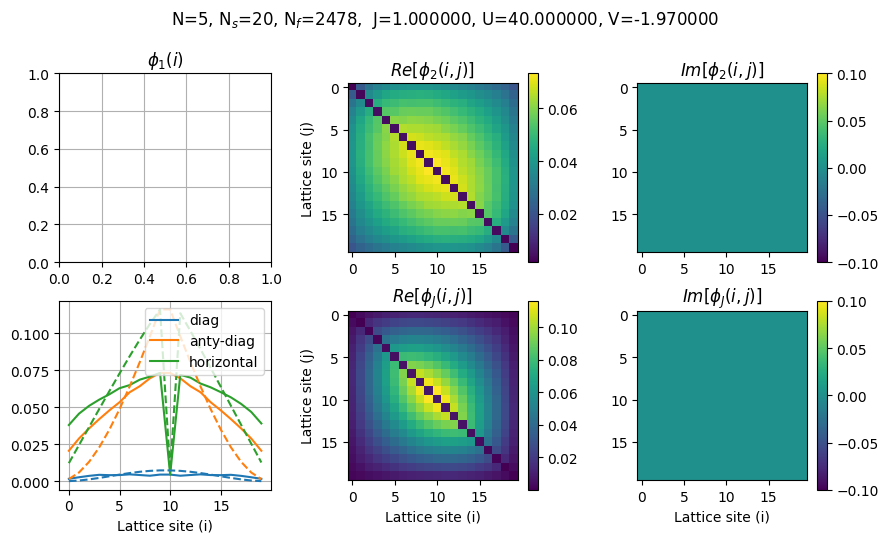

In [84]:
####################################################
## Plot Ansatz functions ###########################
####################################################
phiJ = reshapePhiTo2D(GS_2atom)
phiA21Df /= sqrt(sum(sum(abs(phiA2f)**2)))
phiA2f /= sqrt(sum(sum(abs(phiA2f)**2)))
phiJ /= sqrt(sum(sum(abs(phiJ)**2)))

print('e^{ln(|<DMRG|A2>|^2)/N} = ',exp(log(1-0.5*variance2hf(psi12to14(phiA21Df)))/N))
print('v|<DMRG|A2>|^2 = ',1-0.5*variance2hf(psi12to14(phiA21Df)))

#c2 = normalised( real(array(Norms1)*exp(A2.dot(log(phiA21Df,dtype=complex)))) )
#print('|<ED|A2>|^2 = ',abs(c2.dot(GS_ED))**2)


fig, ax = plt.subplots(2,3,figsize=(9,5.5))
fig.suptitle("N=%i, N$_s$=%i, N$_f$=%i,  J=%f, U=%f, V=%f" % (N, Ns, Nf,J,U,V))

cmap = ax[0,1].imshow(real(phiA2f))
cbar = plt.colorbar(cmap)

cmap = ax[0,2].imshow(imag(phiA2f))
cbar = plt.colorbar(cmap)

cmap = ax[1,1].imshow(real(phiJ))
cbar = plt.colorbar(cmap)
cmap = ax[1,2].imshow(imag(phiJ))
cbar = plt.colorbar(cmap)

ax[1,0].plot([real(phiA2f)[i,i] for i in range(Ns)],label='diag')
ax[1,0].plot([real(phiA2f)[i,Ns-1-i] for i in range(Ns)],label='anty-diag')
ax[1,0].plot([real(phiA2f)[int(Ns/2),i] for i in range(Ns)],label='horizontal')

ax[1,0].plot([real(phiJ)[i,i] for i in range(Ns)],'--',c='tab:blue')
ax[1,0].plot([real(phiJ)[i,Ns-1-i] for i in range(Ns)],'--',c='tab:orange')
ax[1,0].plot([real(phiJ)[int(Ns/2),i] for i in range(Ns)],'--',c='tab:green')


ax[1,0].legend()
ax[0,0].grid()
ax[1,0].grid()
ax[1,0].set_xlabel('Lattice site (i)')
ax[0,1].set_ylabel('Lattice site (j)')

ax[0,0].set_title('$\phi_1(i)$')
ax[0,1].set_title('$Re[\phi_{2}(i,j)]$')
ax[0,2].set_title('$Im[\phi_{2}(i,j)]$')

ax[1,1].set_xlabel('Lattice site (i)')
ax[1,1].set_ylabel('Lattice site (j)')
ax[1,2].set_xlabel('Lattice site (i)')

ax[1,1].set_title('$Re[\phi_J(i,j)]$')
ax[1,2].set_title('$Im[\phi_J(i,j)]$')
plt.tight_layout()
np.save(("DMRG_Ns%i_N%i_J%f_U%f_V%f_Nf%i"%(Ns,N,J,U,V,Nf)),real(phiA2f))
plt.savefig("DMRG_Ns%i_N%i_J%f_U%f_V%f_Nf%i.png"%(Ns,N,J,U,V,Nf))
plt.show()